## Using LSTMs to Predict Mid-Price Movement from the Limit Order Book

- The goal of this notebook is to predict whether the mid-price will decrease, stay the same, or increase during the next tick. This is accomplished through the usage of an LSTM in tensorflow.

### Import the necessary packages

In [1]:
%matplotlib inline
from ml_analysis import MLOperator, MLEvaluator, get_LSTM_data
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import json
import time
import tensorflow as tf
from tensorflow.contrib import rnn
from sklearn.metrics import f1_score

/Users/macbook/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Prepare the data

In [2]:
df = pd.read_csv('all_features_new_intc_fillna_time.csv') # use data with timestamp

df['sprd_chg'] = np.sign(df['actual_spread']-df['actual_spread'].shift(1))
df = df[df['sprd_chg'].isin([0,1])]
df = df[df['label'].isin([-1,1])]
df['sprd_chg'].value_counts() # 1.0    1609
df.drop(columns = 'sprd_chg', inplace = True)

print(len(df))
df = df.dropna()
print(len(df))
train_weight = 0.8
split = int(len(df)*train_weight)
df_train = df[:split]
df_test = df[split:]
operator = MLOperator()
n_steps = 5
use_features = list(df.columns[1:-1]) # instead of df.columns[:-1]
y_train = df_train.label
sampled_idx = operator.get_samples_index(y_train.iloc[n_steps-1:], 'min')
x_train = df_train[use_features]
y_test = df_test.label.iloc[n_steps-1:]
x_test = df_test[use_features]
x_train, y_train, x_test, y_test = get_LSTM_data(x_train, y_train, x_test, y_test, sampled_idx, n_steps)
#normalization
x_max = np.max(x_train,axis=0)
x_min = np.min(x_train,axis=0)
x_train = (x_train - x_min) / (x_max - x_min)
x_test = (x_test - x_min) / (x_max - x_min)
nrow = 150 # 3000
x_valid = x_test[0:nrow]
y_valid = y_test[0:nrow]
x_test = x_test[nrow:]
y_test = y_test[nrow:]
print (x_train.shape,y_train.shape,x_test.shape,y_test.shape, x_valid.shape, y_valid.shape)

3202
3202
(2412, 5, 64) (2412, 2) (487, 5, 64) (487, 2) (150, 5, 64) (150, 2)


In [3]:
# keep track of the timestamp
print(len(sampled_idx))
y_train_time = df_train.loc[sampled_idx,'time']
print(y_train_time.shape)
y_test_time = df_test.time.iloc[n_steps-1:]
y_test_time = y_test_time[nrow:]
print(y_test_time.shape)

resultpath = '/Users/macbook/Desktop/DLFall2018/codes/DL project/tensorflow-master/logs'

filename = resultpath + 'y_train_time_intc_up&down_nolesssprd.csv'
y_train_time_df = pd.DataFrame(y_train_time, columns = ['time'])
y_train_time_df.to_csv(filename, index=False)

filename = resultpath + 'y_test_time_intc_up&down_nolesssprd.csv'
y_test_time_df = pd.DataFrame(y_test_time, columns = ['time'])
y_test_time_df.to_csv(filename, index=False)

2412
(2412,)
(487,)


In [4]:
df.label.value_counts()

-1    1682
 1    1520
Name: label, dtype: int64

### Set the parameters

In [5]:
# Training Parameters
learning_rate = 0.0001

n_epoch = 5000
n_batch = 500
display_step = 100

# Network Parameters
num_input = x_train.shape[-1] # number of features
timesteps = n_steps # timesteps
num_hidden = 7 # hidden layer num of features
num_classes = 2 # up and down

# tf Graph input
# the input variables are first define as placeholder
# a placeholder is a variable/data which will be assigned later
X = tf.placeholder("float", [None, timesteps, num_input]) #dim: batch_size, number of time steps, number of inputs
Y = tf.placeholder("float", [None, num_classes])#dim:batch_size, number of classes (10 here)

#initialize the weigths with a normal random law initialization
weights = {
    'out': tf.Variable(tf.random_normal([num_hidden, num_classes], seed = 4720))
}

biases = {
    'out': tf.Variable(tf.random_normal([num_classes], seed = 4720))
}

### Define the RNN

In [6]:
def RNN(x, weights, biases):
    # Unstack to get a list of 'timesteps' tensors of shape (batch_size, n_input)
    x = tf.unstack(x, timesteps, 1)

    # 1-layer LSTM with num_hidden units
    #rnn_cell = rnn.BasicLSTMCell(num_hidden,activation=tf.nn.sigmoid)
    rnn_cell = rnn.BasicLSTMCell(num_hidden)

    
    # 2-layer LSTM, each layer has num_hidden units. And you can wrap more layers together by doing list comprehension.
    #rnn_cell = rnn.MultiRNNCell([rnn.BasicLSTMCell(num_hidden),rnn.BasicLSTMCell(num_hidden)])

    # Get rnn cell output
    outputs, states = rnn.static_rnn(rnn_cell, x, dtype=tf.float32)

    # (1) Linear activation, using rnn inner loop last output
    return tf.matmul(outputs[-1], weights['out']) + biases['out']


### Define the loss and optimzation

In [7]:
logits = RNN(X, weights, biases)
prediction = tf.nn.softmax(logits)
#define the loss 
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    logits=logits, labels=Y))
#optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)
#tf.equal: Returns the truth value of (x == y) element-wise.
#tf.cast: Casts a tensor to a new type. --- here it casts from boolean to float
#tf.argmax:Returns the index with the largest value across axes of a tensor. --- here along the axis of the vector

correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
init = tf.global_variables_initializer()

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



### Run the model

In [8]:
# Start training
with tf.Session() as sess:
    
    start_time = time.time()
    
    #please, make sure you changed for your own path 
    #log_files_path = '/Users/macbook/Desktop/DLFall2018/codes/DL project/tensorflow-master/logs'
    log_files_path = '/Users/macbook/Desktop/DLFall2018/codes/DL project/tensorflow-master/logs'
    
    #save and restore variables to and from checkpoints.
    saver = tf.train.Saver()

    # Run the initializer
    sess.run(init)
    
    #will work with this later
    #saver.restore(sess, log_files_path+'multi_layer/model-checkpoint-66000')
    
    loss_trace = []
    
    num_examples = x_train.shape[0]

    # Training cycle
    for epoch in range(n_epoch):
        
        avg_cost = 0.
        total_batch = int(num_examples/n_batch)
        
        # Shuffle the data
        np.random.seed(4720)
        perm = np.arange(num_examples)
        np.random.shuffle(perm)
        x_train = x_train[perm]
        y_train = y_train[perm]
                    
        # Loop over all batches
        for i in range(total_batch):
            
            minibatch_x, minibatch_y = x_train[i*n_batch:(i+1)*n_batch], y_train[i*n_batch:(i+1)*n_batch]

            #minibatch_x, minibatch_y = mnist.train.next_batch(batch_size)
            
            # Fit training using batch data
            #the training is done using the training dataset
            sess.run(train_op, feed_dict={X: minibatch_x, Y: minibatch_y})
            # Compute average loss
            avg_cost += sess.run(loss_op, feed_dict={X: minibatch_x, Y: minibatch_y})/total_batch
        
        # Display logs per epoch step
        if epoch % display_step == 0:
                    
            #the accuracy is evaluated using the validation dataset
            train_acc = sess.run(accuracy, feed_dict={X: x_train, Y: y_train})
            val_cost = sess.run(loss_op, feed_dict={X: x_valid, Y: y_valid})
            acc = sess.run(accuracy, feed_dict={X: x_valid, Y: y_valid})
            loss_trace.append(1-acc)    
            print("Epoch:", '%04d' % (epoch+1), "train_loss :", "{:0.4f}".format(avg_cost), "train_acc :", "{:0.4f}".format(train_acc), \
                  "val_loss :", "{:0.4f}".format(val_cost), "val_acc :", "{:0.4f}".format(acc))    
    
    #save to use later
    saver.save(sess, log_files_path)
    
    print("Optimization Finished!")
    #accuracy evaluated with the whole test dataset
    acc = sess.run(accuracy, feed_dict={X: x_test, Y: y_test})
    print("Test Accuracy:", acc)
                    
    elapsed_time = time.time() - start_time
    print('Execution time (seconds) was %0.3f' % elapsed_time)

Epoch: 0001 train_loss : 0.9886 train_acc : 0.5000 val_loss : 0.8618 val_acc : 0.5200
Epoch: 0101 train_loss : 0.6367 train_acc : 0.6915 val_loss : 0.6136 val_acc : 0.7133
Epoch: 0201 train_loss : 0.5474 train_acc : 0.7823 val_loss : 0.5254 val_acc : 0.7867
Epoch: 0301 train_loss : 0.4720 train_acc : 0.8449 val_loss : 0.4434 val_acc : 0.8400
Epoch: 0401 train_loss : 0.4259 train_acc : 0.8516 val_loss : 0.3854 val_acc : 0.8600
Epoch: 0501 train_loss : 0.3996 train_acc : 0.8566 val_loss : 0.3490 val_acc : 0.8933
Epoch: 0601 train_loss : 0.3659 train_acc : 0.8570 val_loss : 0.3290 val_acc : 0.8933
Epoch: 0701 train_loss : 0.3636 train_acc : 0.8586 val_loss : 0.3154 val_acc : 0.8933
Epoch: 0801 train_loss : 0.3579 train_acc : 0.8607 val_loss : 0.3077 val_acc : 0.8933
Epoch: 0901 train_loss : 0.3443 train_acc : 0.8628 val_loss : 0.3010 val_acc : 0.8933
Epoch: 1001 train_loss : 0.3343 train_acc : 0.8644 val_loss : 0.2961 val_acc : 0.8933
Epoch: 1101 train_loss : 0.3250 train_acc : 0.8661 val

### Evaluate the model

In [9]:
# returns a compiled model
# identical to the previous one
with tf.Session() as sess:
    resultpath = '/Users/macbook/Desktop/DLFall2018/codes/DL project/tensorflow-master/logs'
    saver = tf.train.Saver()
    saver.restore(sess, log_files_path)
    
    pred = sess.run(prediction, feed_dict={X: x_train, Y: y_train})    
    pred_df_train = pd.DataFrame(pred, columns=['-1', '1'])
    pred_df_train['predict'] = pred_df_train.idxmax(axis=1)
    pred_df_train['true'] = pd.DataFrame(y_train, columns=['-1','1']).idxmax(axis=1)
    
    filename = resultpath + 'pred_train_intc_up&down_nolesssprd.csv'
    pred_df_train.to_csv(filename, index=False)
    
    pred = sess.run(prediction, feed_dict={X: x_test, Y: y_test})    
    pred_df_test = pd.DataFrame(pred, columns=['-1', '1'])
    pred_df_test['predict'] = pred_df_test.idxmax(axis=1)
    pred_df_test['true'] = pd.DataFrame(y_test, columns=['-1', '1']).idxmax(axis=1)  
    
    filename = resultpath + 'pred_test_intc_up&down_nolesssprd.csv'
    pred_df_test.to_csv(filename, index=False)
    
    
train_f1 = f1_score(pred_df_train.true, pred_df_train.predict, average=None)
test_f1 = f1_score(pred_df_test.true, pred_df_test.predict, average=None)
print (train_f1)
print (test_f1)

INFO:tensorflow:Restoring parameters from /Users/macbook/Desktop/DLFall2018/codes/DL project/tensorflow-master/logs
[0.93195021 0.93206297]
[0.85658153 0.84301075]


### Results on training data

Confusion matrix, without normalization
[[1123   83]
 [  81 1125]]
Normalized confusion matrix
[[0.93117745 0.06882255]
 [0.06716418 0.93283582]]


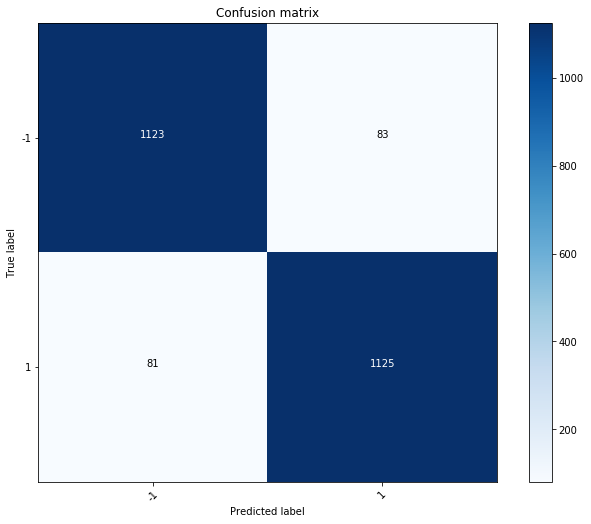

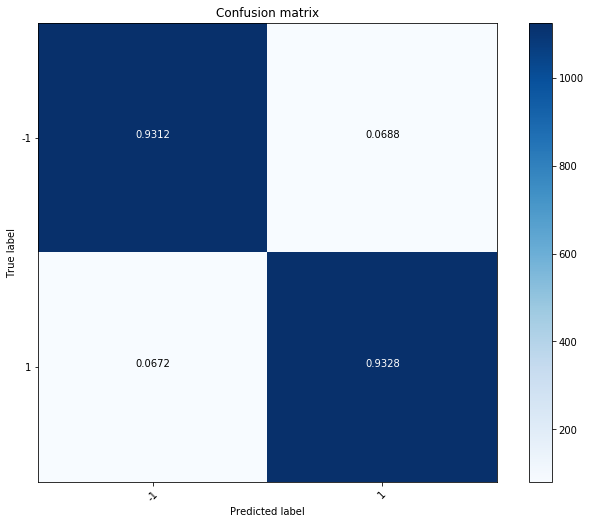

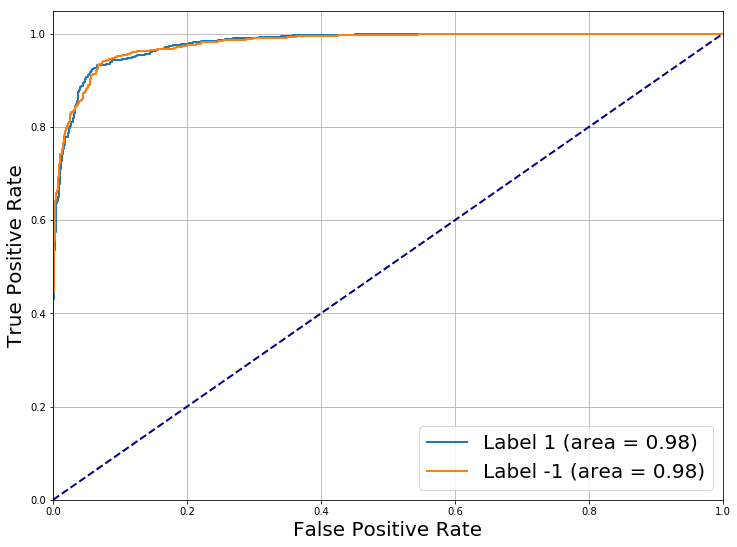

In [10]:
evaluator = MLEvaluator()
evaluator.set_pred_df(pred_df_train)
cf_mx_train = evaluator.generate_confusion_matrix()

fig = evaluator.plot_confusion_matrix(cf_mx_train.values, [-1, 1])
fig = evaluator.plot_confusion_matrix(cf_mx_train.values, [-1, 1], normalize=True)
fig = evaluator.plot_roc()

### Results on testing data

Confusion matrix, without normalization
[[218  36]
 [ 37 196]]
Normalized confusion matrix
[[0.85826772 0.14173228]
 [0.15879828 0.84120172]]


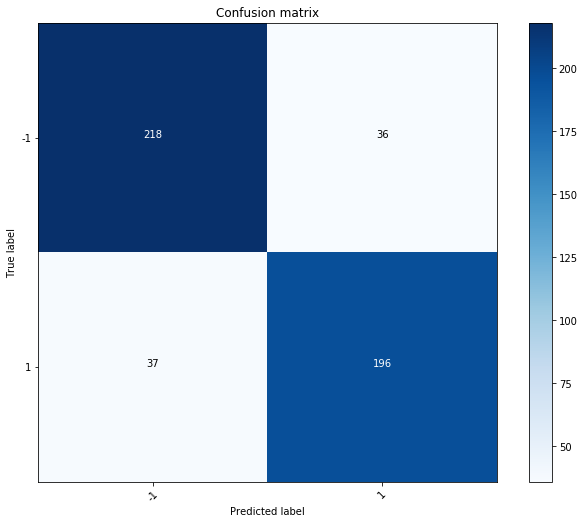

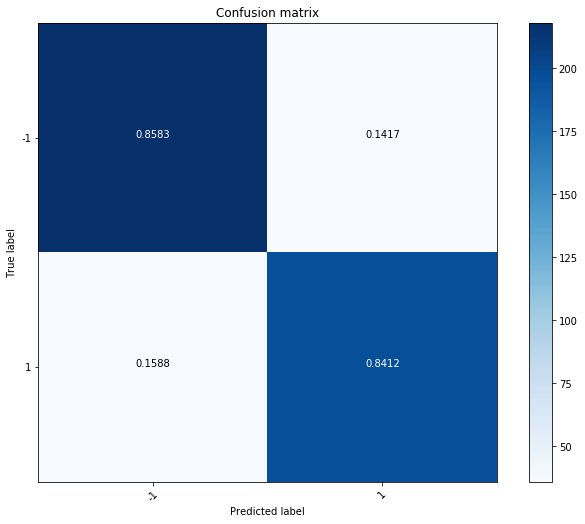

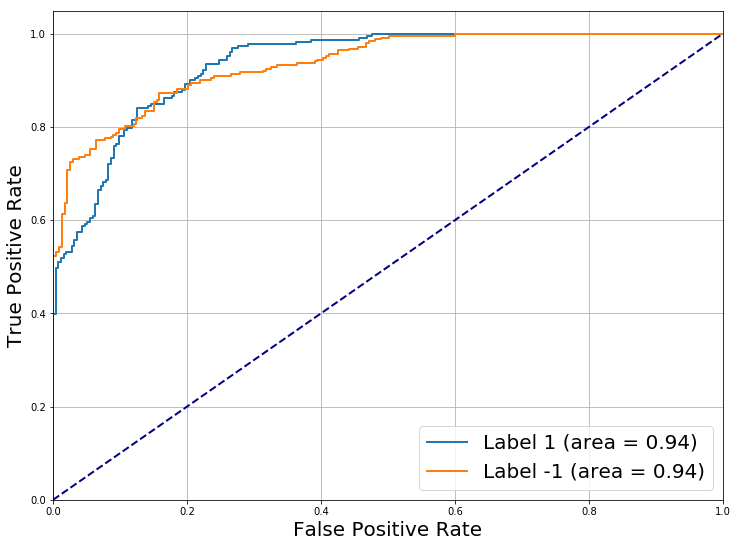

In [11]:
evaluator.set_pred_df(pred_df_test)
cf_mx_test = evaluator.generate_confusion_matrix()

fig = evaluator.plot_confusion_matrix(cf_mx_test.values, [-1, 1])
fig = evaluator.plot_confusion_matrix(cf_mx_test.values, [-1, 1], normalize=True)
fig = evaluator.plot_roc()